In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import genextreme
import os
import sys

operating_system = 'mac'

if operating_system == 'win':
    os.chdir('C:/Users/fabau/OneDrive/Documents/GitHub/master-project-cleaned/')
elif operating_system == 'curnagl':
    os.chdir('/work/FAC/FGSE/IDYST/tbeucler/default/fabien/repos/cleaner_version/')
else:
    os.chdir('/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/')

util_perso = os.path.abspath('util/gev')
sys.path.append(util_perso)
util_perso = os.path.abspath('util/processing')
sys.path.append(util_perso)

import time_series
from data_processing import depickle

/Users/fabienaugsburger/anaconda3/envs/master/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LinearRegression from version 1.3.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


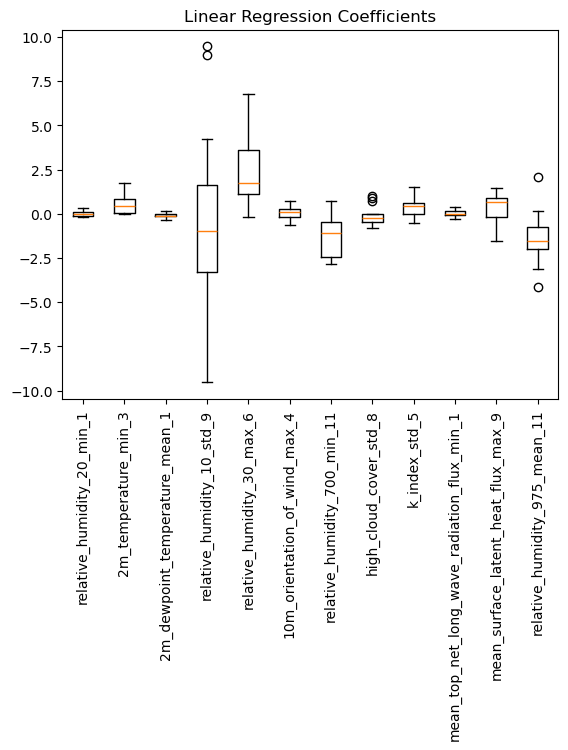

In [5]:
final = '_final'

model_z = depickle(f'analysis_loadings_selected/z_gust{final}/best_linear_cdf_model.pkl')
model_u = depickle(f'analysis_loadings_selected/u_gust{final}/best_linear_max_model.pkl')
features_z = pd.DataFrame(depickle(f'analysis_loadings_selected/z_gust{final}/best_linear_cdf_feature.pkl'),
                        columns = ['var_name', 'PC'])
features_u = pd.DataFrame(depickle(f'analysis_loadings_selected/u_gust{final}/best_linear_max_feature.pkl'),
                        columns = ['var_name', 'PC'])


# get the coefficients
coefficients = model_z.coef_
# Print feature names alongside coefficients
feature_names = features_z['var_name']+'_'+(features_z['PC']+1).astype(str)


plt.boxplot(coefficients)
plt.xticks(range(1, len(feature_names)+1), feature_names, rotation=90)

if coefficients.shape == 1:
    for feature_name, coef in zip(feature_names, coefficients):
        print(f"{feature_name}: {coef:.3f}")

    # Sort by absolute value
    sorted_indices = np.argsort(np.abs(coefficients))[::-1]  # descending order
    sorted_coefs = coefficients[sorted_indices]
    sorted_names = feature_names[sorted_indices]

    plt.figure(figsize=(10, 10))
    bars = plt.bar(sorted_names, sorted_coefs)

    # You can also color-code bars by sign if you want:
    for bar, coef in zip(bars, sorted_coefs):
        bar.set_color('g' if coef >= 0 else 'r')
    #plt.bar(sorted_names, sorted_coefs)
    plt.xticks(rotation=90)
    plt.ylabel('Coefficient value')
plt.title(f'Linear Regression Coefficients')
#plt.tight_layout()
plt.show()

### Prediction on the validation set

In [11]:

'''if final is not None:
    final_test = ' 2'
    final_folder = '_final'
    '''

pcaall = depickle(f'analysis_loadings_selected/PCA_fred{final}/pcaall.pkl')

pcsall_train = depickle(f'analysis_loadings_selected/PCA_fred{final}/pcsall_train.pkl')
pcsall_test = depickle(f'analysis_loadings_selected/PCA_fred{final}/pcsall_test.pkl')
pcsall_valid = depickle(f'analysis_loadings_selected/PCA_fred{final}/pcsall_valid.pkl')

# the storm number linked to the index
train_number = pd.read_csv('ml_scripts/new_feature_selection/seed_42/X_train_ts_all.csv')['storm_index']
valid_number = pd.read_csv('ml_scripts/new_feature_selection/seed_42/X_validation_ts_all.csv')['storm_index']
test_number = pd.read_csv('ml_scripts/new_feature_selection/seed_42/X_test_ts_all.csv')['storm_index']

train_valid = pd.concat([train_number, valid_number], axis=0).reset_index(drop=True)

# loadings on the train set, validation set and test set
train_sets = depickle('analysis_loadings_selected/PCA_fred/train_sets.pkl')[0]
val_sets = depickle('analysis_loadings_selected/PCA_fred/val_sets.pkl')[0]

pcs0_train = pcsall_train[0]
pcs0_valid = pcsall_valid[0]
pcs0_test = pcsall_test[0]

output_type = ['cdf']

for out in output_type:
    if out == 'max':
        folder = 'u_gust'
    else:
        folder = 'z_gust'

    var_selected = features = pd.DataFrame(depickle(f'analysis_loadings_selected/{folder}/best_linear_{out}_feature.pkl'),
                        columns = ['var_name', 'PC'])
    var_selected ['var_name_pca'] = var_selected ['var_name']+ '_PC'+ var_selected ['PC'].astype(str)

    loading_train = []
    loading_valid = []
    loading_test = []

    eigenvectors = {}

    for var in var_selected['var_name']:

        pcn = var_selected[var_selected['var_name']==var]['PC'].values[0]
        print(var)

        # combine all loadings for the selected variables in one dataframe with the variable names as index and the storm number as columns
        temp_loading_allpcn_train = pcs0_train[var][:]
        temp_loading_seppcn_train = temp_loading_allpcn_train[:,pcn]
        loading_train.append(temp_loading_seppcn_train)

        temp_loading_allpcn_valid = pcs0_valid[var][:]
        temp_loading_seppcn_valid = temp_loading_allpcn_valid[:,pcn]
        loading_valid.append(temp_loading_seppcn_valid)

        temp_loading_allpcn_test = pcs0_test[var][:]
        temp_loading_seppcn_test = temp_loading_allpcn_test[:,pcn]
        loading_test.append(temp_loading_seppcn_test)

        # extract the scores from pcaall
        scores = {}  # dictionary to store dataframes

        #if  var.startswith('10m_'):
        #    continue
        #if var.startswith('mean_sea_level_pressure_min'):
        #    continue
        #loadings[var] = pd.read_csv(f'data/PCA/PCA_loadings_1000/{var}.csv')#.drop(columns=['variable'])
        eigenvectors[var] = pcaall[var].components_[pcn,:] # or vector
        #explained_variance_10 = pcaall[var].explained_variance_[:10] # or value
        #loadings[var] = pd.DataFrame(loadings_10, columns=[f'PCA_{i+1}' for i in range(10)])
        #scores[var] = pd.read_csv(f'data/PCA/PCA_scores_1000/{var}.csv').drop(columns=['variable'])

loading_train = np.array(loading_train)
loading_train = pd.DataFrame(loading_train, 
                            index=var_selected['var_name_pca'],
                            columns=train_sets)
loading_valid = np.array(loading_valid)
loading_valid = pd.DataFrame(loading_valid, 
                            index=var_selected['var_name_pca'],
                            columns=val_sets)
loading_test = np.array(loading_test)
loading_test = pd.DataFrame(loading_test, 
                            index=var_selected['var_name_pca'],
                            columns=test_number)

loadings_train_valid = pd.concat([loading_train, loading_valid], axis=1)

loadings_train_valid = loadings_train_valid.rename(columns=train_valid)

loadings_all = pd.concat([loadings_train_valid, loading_test], axis=1).T

/Users/fabienaugsburger/anaconda3/envs/master/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.3.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


2m_temperature_std
relative_humidity_300_mean
geopotential_500_max
convective_available_potential_energy_max
relative_humidity_975_mean
100m_orientation_of_wind_min
relative_humidity_70_min
total_precipitation_std
relative_humidity_500_max
100m_magnitude_of_wind_mean
total_totals_index_min
2m_temperature_max
relative_humidity_700_std
relative_humidity_300_max
relative_humidity_400_std
surface_sensible_heat_flux_max
relative_humidity_20_std
relative_humidity_400_max
10m_orientation_of_wind_mean
2m_temperature_mean
relative_humidity_250_min
mean_surface_latent_heat_flux_std
relative_humidity_70_std
10m_orientation_of_wind_std
relative_humidity_50_mean
relative_humidity_50_min
high_cloud_cover_max


/Users/fabienaugsburger/anaconda3/envs/master/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/Users/fabienaugsburger/anaconda3/envs/master/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/Users/fabienaugsburger/anaconda3/envs/master/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/Users/fabienaugsburger/anaconda3/envs/master/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/Users/fabienaugsburger/anaconda3/envs/master/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.w

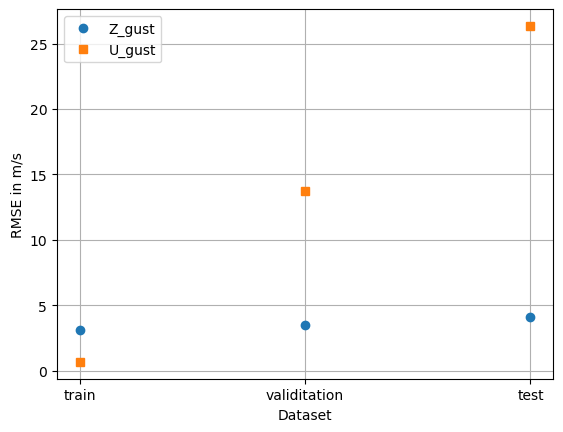

In [72]:
prediction_z_train = model_z.predict(loading_train.T)
prediction_u_train = model_u.predict(loading_train.T)
prediction_z_valid = model_z.predict(loading_valid.T)
prediction_u_valid = model_u.predict(loading_valid.T)
prediction_z_test = model_z.predict(loading_test.T)
prediction_u_test = model_u.predict(loading_test.T)

prediction_z_train_valid = model_z.predict(loadings_train_valid.T)
prediction_u_train_valid = model_u.predict(loadings_train_valid.T)
true_winds = pd.read_csv('data/climatology_dm_winter_per_cluster/EVENT_max/max_event_dm_combined.csv', index_col=0)

rmses_z = []
rmses_u = []

for (prediction_z, prediction_u) in zip(
    (prediction_z_train, prediction_z_valid, prediction_z_test),
    (prediction_u_train, prediction_u_valid, prediction_u_test)
):
#true_winds_Vivian = true_winds[true_winds['storm_name'] == 'VIVIAN']
#for n in range(3):
    n = 3

    cluster_z = prediction_z[n,:]
    cluster_u = prediction_u[n,:]

    true_winds_mean = np.mean(true_winds.drop(columns='storm_name'), axis=0)
    prediction_z_mean = np.mean(prediction_z, axis=0)
    prediction_u_mean = np.mean(prediction_u, axis=0)

    cluster_u = pd.DataFrame(cluster_u, columns=['cluster_u'])

    '''max_cluster_z = np.max(cluster_z)
    min_cluster_z = np.min(cluster_z)

    max_cluster_u = np.max(cluster_u)
    min_cluster_u = np.min(cluster_u)'''

    # cluster_z_3 = cluster_z[3]
    # cluster_u_3 = cluster_u[3]

    cluster_z_wind = []
    cluster_z_wind_mean = []

    for i in range(15):

        cluster_z_3 = cluster_z[i]

        cluster_mean_z = prediction_z_mean[i]

        # for cluster n°3
        param = pd.read_csv(f'data/climatology_dm_winter_per_cluster/GEV_parameters/GEV_parameters_cluster_{n+1}.csv', index_col=0)
        shape_param= param.iloc[0].values
        loc_param = param.iloc[1].values
        scale_param = param.iloc[2].values

        max_cluster_z_perc = 1-np.exp(-cluster_z_3)
        cluster_mean_z_perc = 1-np.exp(-cluster_mean_z)
        # Percentile (e.g., 90%)
        percentile = max_cluster_z_perc

        # Calculate wind speed at the given percentile
        wind_speed_z = genextreme.ppf(percentile, c=shape_param, loc=loc_param, scale=scale_param)
        wind_speed_z_mean = genextreme.ppf(cluster_mean_z_perc, c=shape_param, loc=loc_param, scale=scale_param)
        cluster_z_wind.append(wind_speed_z)
        cluster_z_wind_mean.append(wind_speed_z_mean)

    cluster_z_wind = pd.DataFrame(cluster_z_wind, columns=['cluster_z_wind'])
    cluster_z_wind_mean = pd.DataFrame(cluster_z_wind_mean, columns=['cluster_z_wind_mean'])

    #true_winds_Vivian = true_winds_Vivian.T[1:].reset_index(drop=True)
    #true_winds_Vivian = true_winds_Vivian.rename(columns={5: 'true_winds_Vivian'})

    true_winds_mean = pd.DataFrame(true_winds_mean, columns=['true_winds_mean']).reset_index(drop=True)
    prediction_u_mean = pd.DataFrame(prediction_u_mean, columns=['prediction_u_mean'])

#winds_vivian = pd.concat([true_winds_Vivian, cluster_z_wind, cluster_u], axis=1)
#winds_vivian.to_csv('analysis_loadings_selected/figures/winds_vivian.csv')


    winds_cluster_mean = pd.concat([true_winds_mean, cluster_z_wind_mean, prediction_u_mean], axis=1)
    winds_error_z = winds_cluster_mean['true_winds_mean'] - winds_cluster_mean['cluster_z_wind_mean']
    winds_error_u = winds_cluster_mean['true_winds_mean'] - winds_cluster_mean['prediction_u_mean']
    rmse_z = np.sqrt(np.mean(winds_error_z**2))
    rmse_u = np.sqrt(np.mean(winds_error_u**2))
    rmses_z.append(rmse_z)
    rmses_u.append(rmse_u)

plt.plot(rmses_z, label='Z_gust', marker='o', linestyle='None')
plt.plot(rmses_u, label='U_gust', marker='s', linestyle='None')
plt.xticks(range(3), ['train', 'validitation', 'test'])
plt.xlabel('Dataset')
plt.ylabel('RMSE in m/s')
plt.grid()
plt.legend()
plt.savefig('analysis_loadings_selected/figures/rmse_z_u_gust.png', dpi=300)


2m_temperature_std_3: -0.789
relative_humidity_300_mean_11: 3.636
geopotential_500_max_10: -2.924
convective_available_potential_energy_max_4: 1.473
relative_humidity_975_mean_11: -2.364
100m_orientation_of_wind_min_10: -0.917
relative_humidity_70_min_3: -0.866
total_precipitation_std_5: -1.290
relative_humidity_500_max_8: -0.348
100m_magnitude_of_wind_mean_5: 0.158
total_totals_index_min_2: 0.210
2m_temperature_max_10: -13.700
relative_humidity_700_std_9: 0.609
relative_humidity_300_max_11: 2.146
relative_humidity_400_std_10: 2.441
surface_sensible_heat_flux_max_9: 4.210
relative_humidity_20_std_9: 3.393
relative_humidity_400_max_10: 0.012
10m_orientation_of_wind_mean_3: 0.492
2m_temperature_mean_8: -1.217
relative_humidity_250_min_5: -0.343
mean_surface_latent_heat_flux_std_8: 3.054
relative_humidity_70_std_7: -1.665
10m_orientation_of_wind_std_4: -0.238
relative_humidity_50_mean_7: 0.137
relative_humidity_50_min_4: 0.293
high_cloud_cover_max_8: 11.958


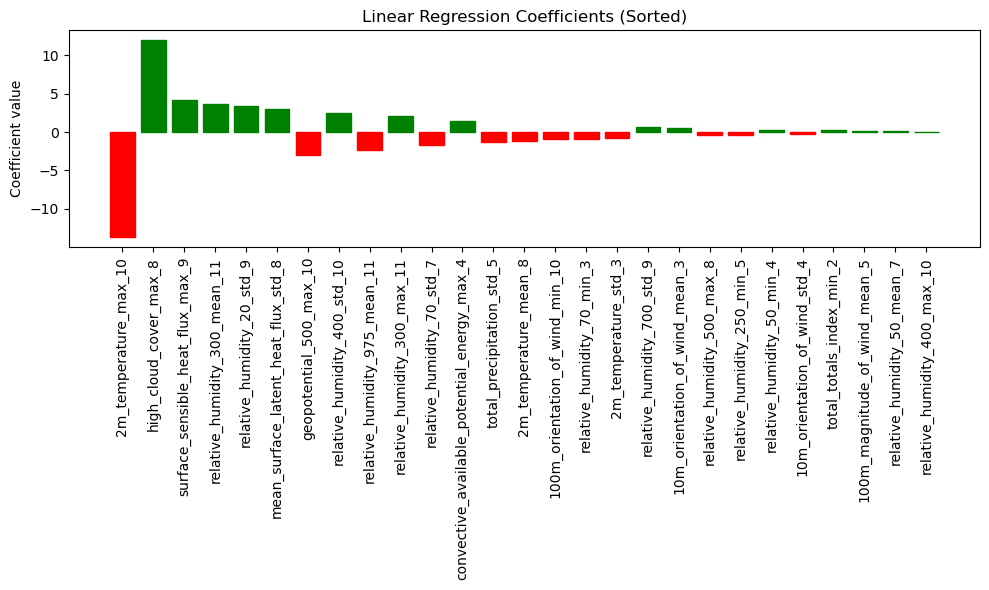

Features ranked by importance: ['2m_temperature_max_10', 'high_cloud_cover_max_8', 'surface_sensible_heat_flux_max_9', 'relative_humidity_300_mean_11', 'relative_humidity_20_std_9', 'mean_surface_latent_heat_flux_std_8', 'geopotential_500_max_10', 'relative_humidity_400_std_10', 'relative_humidity_975_mean_11', 'relative_humidity_300_max_11', 'relative_humidity_70_std_7', 'convective_available_potential_energy_max_4', 'total_precipitation_std_5', '2m_temperature_mean_8', '100m_orientation_of_wind_min_10', 'relative_humidity_70_min_3', '2m_temperature_std_3', 'relative_humidity_700_std_9', '10m_orientation_of_wind_mean_3', 'relative_humidity_500_max_8', 'relative_humidity_250_min_5', 'relative_humidity_50_min_4', '10m_orientation_of_wind_std_4', 'total_totals_index_min_2', '100m_magnitude_of_wind_mean_5', 'relative_humidity_50_mean_7', 'relative_humidity_400_max_10']


In [36]:

# extract cluster 3 from the coefficients of the linear regression
coeff_cluster_3 = coefficients[3]

# plot the coefficients of the linear regression
for feature_name, coef in zip(feature_names, coeff_cluster_3):
    print(f"{feature_name}: {coef:.3f}")

# Sort by absolute value
sorted_indices = np.argsort(np.abs(coeff_cluster_3))[::-1]  # descending order
sorted_coefs = coeff_cluster_3[sorted_indices]
sorted_names = feature_names[sorted_indices]

plt.figure(figsize=(10, 6))
bars = plt.bar(sorted_names, sorted_coefs)

# You can also color-code bars by sign if you want:
for bar, coef in zip(bars, sorted_coefs):
    bar.set_color('g' if coef >= 0 else 'r')
#plt.bar(sorted_names, sorted_coefs)
plt.xticks(rotation=90)
plt.ylabel('Coefficient value')
plt.title(f'Linear Regression Coefficients (Sorted)')
plt.tight_layout()
plt.show()

coefs_abs = np.abs(coeff_cluster_3)
ranked_features = [feature for _, feature in sorted(zip(coefs_abs, feature_names), reverse=True)]
print("Features ranked by importance:", ranked_features)

In [15]:
rmses_u_all = []
rmses_z_all = []
for a in range(7):
    print(a)
    pcs0_train = pcsall_train[a] #pd.read_csv(f'analysis_loadings_selected/PCA_fred_final/yn/ytrain_split_{a}.pkl')#pcsall_train[a]
    pcs0_valid = pcsall_valid[a]# pd.read_csv(f'analysis_loadings_selected/PCA_fred_final/yn/yvalid_split_{a}.pkl')#pcsall_valid[a]
    pcs0_test = pcsall_test[a]

    output_type = ['cdf']

    for out in output_type:
        if out == 'max':
            folder = f'u_gust{final}'
        else:
            folder = f'z_gust{final}'

        var_selected = features = pd.DataFrame(depickle(f'analysis_loadings_selected/{folder}/best_linear_{out}_feature.pkl'),
                            columns = ['var_name', 'PC'])
        var_selected ['var_name_pca'] = var_selected ['var_name']+ '_PC'+ var_selected ['PC'].astype(str)

        loading_train = []
        loading_valid = []
        loading_test = []

        eigenvectors = {}

        for var in var_selected['var_name']:

            pcn = var_selected[var_selected['var_name']==var]['PC'].values[0]
            #print(var)

            # combine all loadings for the selected variables in one dataframe with the variable names as index and the storm number as columns
            temp_loading_allpcn_train = pcs0_train[var][:]
            temp_loading_seppcn_train = temp_loading_allpcn_train[:,pcn]
            loading_train.append(temp_loading_seppcn_train)

            temp_loading_allpcn_valid = pcs0_valid[var][:]
            temp_loading_seppcn_valid = temp_loading_allpcn_valid[:,pcn]
            loading_valid.append(temp_loading_seppcn_valid)

            temp_loading_allpcn_test = pcs0_test[var][:]
            temp_loading_seppcn_test = temp_loading_allpcn_test[:,pcn]
            loading_test.append(temp_loading_seppcn_test)

            # extract the scores from pcaall
            scores = {}  # dictionary to store dataframes

            #if  var.startswith('10m_'):
            #    continue
            #if var.startswith('mean_sea_level_pressure_min'):
            #    continue
            #loadings[var] = pd.read_csv(f'data/PCA/PCA_loadings_1000/{var}.csv')#.drop(columns=['variable'])
            eigenvectors[var] = pcaall[var].components_[pcn,:] # or vector
            #explained_variance_10 = pcaall[var].explained_variance_[:10] # or value
            #loadings[var] = pd.DataFrame(loadings_10, columns=[f'PCA_{i+1}' for i in range(10)])
            #scores[var] = pd.read_csv(f'data/PCA/PCA_scores_1000/{var}.csv').drop(columns=['variable'])

    loading_train = np.array(loading_train)
    loading_train = pd.DataFrame(loading_train, 
                                index=var_selected['var_name_pca'],
                                columns=train_sets)
    loading_valid = np.array(loading_valid)
    loading_valid = pd.DataFrame(loading_valid, 
                                index=var_selected['var_name_pca'],
                                columns=val_sets)
    loading_test = np.array(loading_test)
    loading_test = pd.DataFrame(loading_test, 
                                index=var_selected['var_name_pca'],
                                columns=test_number)
    loading_test_clean = loading_test.T
    loading_test_clean = loading_test_clean[loading_test_clean.iloc[:, 0] != 'storm_index']

    loadings_train_valid = pd.concat([loading_train, loading_valid], axis=1)

    loadings_train_valid = loadings_train_valid.rename(columns=train_valid)

    loadings_all = pd.concat([loadings_train_valid, loading_test], axis=1).T

    prediction_z_train = model_z.predict(loading_train.T)
    #prediction_u_train = model_u.predict(loading_train.T)
    prediction_z_valid = model_z.predict(loading_valid.T)
    #prediction_u_valid = model_u.predict(loading_valid.T)
    prediction_z_test = model_z.predict(loading_test_clean)
    #prediction_u_test = model_u.predict(loading_test_clean)

    prediction_z_train_valid = model_z.predict(loadings_train_valid.T)
    #prediction_u_train_valid = model_u.predict(loadings_train_valid.T)
    true_winds = pd.read_csv('data/climatology_dm_winter_per_cluster/EVENT_max/max_event_dm_combined.csv', index_col=0)

    rmses_z = []
    rmses_u = []

    for (prediction_z, prediction_u) in zip(
        (prediction_z_train, prediction_z_valid, prediction_z_test),
        (prediction_u_train, prediction_u_valid, prediction_u_test)
    ):
    #true_winds_Vivian = true_winds[true_winds['storm_name'] == 'VIVIAN']
    #for n in range(3):
        n = 3

        cluster_z = prediction_z[n,:]
        cluster_u = prediction_u[n,:]

        true_winds_mean = np.mean(true_winds.drop(columns='storm_name'), axis=0)
        prediction_z_mean = np.mean(prediction_z, axis=0)
        prediction_u_mean = np.mean(prediction_u, axis=0)

        cluster_u = pd.DataFrame(cluster_u, columns=['cluster_u'])

        '''max_cluster_z = np.max(cluster_z)
        min_cluster_z = np.min(cluster_z)

        max_cluster_u = np.max(cluster_u)
        min_cluster_u = np.min(cluster_u)'''

        # cluster_z_3 = cluster_z[3]
        # cluster_u_3 = cluster_u[3]

        cluster_z_wind = []
        cluster_z_wind_mean = []

        for i in range(15):

            cluster_z_3 = cluster_z[i]

            cluster_mean_z = prediction_z_mean[i]

            # for cluster n°3
            param = pd.read_csv(f'data/climatology_dm_winter_per_cluster/GEV_parameters/GEV_parameters_cluster_{n+1}.csv', index_col=0)
            shape_param= param.iloc[0].values
            loc_param = param.iloc[1].values
            scale_param = param.iloc[2].values

            max_cluster_z_perc = 1-np.exp(-cluster_z_3)
            cluster_mean_z_perc = 1-np.exp(-cluster_mean_z)
            # Percentile (e.g., 90%)
            percentile = max_cluster_z_perc

            # Calculate wind speed at the given percentile
            wind_speed_z = genextreme.ppf(percentile, c=shape_param, loc=loc_param, scale=scale_param)
            wind_speed_z_mean = genextreme.ppf(cluster_mean_z_perc, c=shape_param, loc=loc_param, scale=scale_param)
            cluster_z_wind.append(wind_speed_z)
            cluster_z_wind_mean.append(wind_speed_z_mean)

        cluster_z_wind = pd.DataFrame(cluster_z_wind, columns=['cluster_z_wind'])
        cluster_z_wind_mean = pd.DataFrame(cluster_z_wind_mean, columns=['cluster_z_wind_mean'])

        #true_winds_Vivian = true_winds_Vivian.T[1:].reset_index(drop=True)
        #true_winds_Vivian = true_winds_Vivian.rename(columns={5: 'true_winds_Vivian'})

        true_winds_mean = pd.DataFrame(true_winds_mean, columns=['true_winds_mean']).reset_index(drop=True)
        prediction_u_mean = pd.DataFrame(prediction_u_mean, columns=['prediction_u_mean'])

    #winds_vivian = pd.concat([true_winds_Vivian, cluster_z_wind, cluster_u], axis=1)
    #winds_vivian.to_csv('analysis_loadings_selected/figures/winds_vivian.csv')


        winds_cluster_mean = pd.concat([true_winds_mean, cluster_z_wind_mean, prediction_u_mean], axis=1)
        winds_error_z = winds_cluster_mean['true_winds_mean'] - winds_cluster_mean['cluster_z_wind_mean']
        winds_error_u = winds_cluster_mean['true_winds_mean'] - winds_cluster_mean['prediction_u_mean']
        rmse_z = np.sqrt(np.mean(winds_error_z**2))
        rmse_u = np.sqrt(np.mean(winds_error_u**2))


        print(rmse_z)
        print(rmse_u)

        rmses_z.append(rmse_z)
        rmses_u.append(rmse_u)

    rmses_u_all.append(rmses_u)
    rmses_z_all.append(rmses_z)

rmses_z_all_averaged = np.mean(rmses_z_all, axis=0)
rmses_u_all_averaged = np.mean(rmses_u_all, axis=0)

pd.DataFrame(rmses_z_all_averaged).to_csv('analysis_loadings_selected/figures/rmse_z_all.csv')
pd.DataFrame(rmses_u_all_averaged).to_csv('analysis_loadings_selected/figures/rmse_u_all.csv')

plt.plot(rmses_z_all_averaged, label='Z_gust', marker='o', linestyle='None')
plt.plot(rmses_u_all_averaged, label='U_gust', marker='s', linestyle='None')
plt.xticks(range(3), ['train', 'validation', 'test'])
plt.xlabel('Dataset')
plt.ylabel('RMSE in m/s')
plt.grid()
plt.legend()
#plt.savefig('analysis_loadings_selected/figures/rmse_z_u_gust.png', dpi=300)


0


/Users/fabienaugsburger/anaconda3/envs/master/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/Users/fabienaugsburger/anaconda3/envs/master/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/Users/fabienaugsburger/anaconda3/envs/master/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/Users/fabienaugsburger/anaconda3/envs/master/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


NameError: name 'prediction_u_train' is not defined

In [104]:
pcsall_valid[6]

{'total_precipitation_std': array([[ 7.94201278e+00,  2.94037007e+00,  3.34083534e-01,
         -2.00517906e-01,  4.67356263e-01,  4.76784924e-01,
         -8.49423554e-02, -2.20664092e-01, -3.38994362e-02,
         -1.27558616e-01, -2.39930251e-03],
        [ 4.28665939e+00,  4.48122676e+00,  1.76291398e-01,
          2.74335250e-01, -6.15580938e-01, -9.02471732e-02,
         -3.47599270e-01,  6.20506493e-01, -2.35117530e-01,
         -1.43697973e-01,  6.95734882e-02],
        [-1.96923482e+00, -1.42775240e+00,  1.34073771e+00,
          3.91877974e-01, -4.36387964e-01, -8.65329038e-02,
         -4.94590079e-02,  1.40971048e-01,  6.67254364e-03,
         -8.36554253e-02, -4.15300694e-02],
        [-8.82497721e-01, -4.05486313e-01,  1.64028862e-01,
          1.25399432e-01, -2.78750816e-01, -2.14912300e-01,
          1.52162166e-01, -2.65568068e-01, -9.51840575e-02,
         -6.68777750e-02,  1.29303869e-01],
        [-2.22901122e-01,  1.46853675e-01,  2.34793849e-01,
         -8.51521